In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc
import pandas as pd

import os

from lib.Diccionariacion import awards_wipo, awards_gdp, wipo_gdp
from lib.Tratamiento import inv_dict, interchange_dict
from scipy.optimize import curve_fit
from scipy.stats import linregress, spearmanr
from scipy.optimize import least_squares

In [2]:
#Diccionario OEC

awards_OEC = {
    'Jordan': 'Jordan',
    'Romania': 'Romania',
    'Lebanon': 'Lebanon',
    'South Africa': 'South Africa',
    'France': 'France',
    'Kyrgyzstan': 'Kyrgyzstan',
    'Poland': 'Poland',
    'Chile': 'Chile',
    'Kenya': 'Kenya',
    'Malaysia': 'Malaysia',
    'Chinese Taipei': 'Chinese Taipei',
    'Canada': 'Canada',
    'Turkey': 'Turkey',
    'China': 'China',
    'Italy': 'Italy',
    'United States': 'United States',
    'Cuba': 'Cuba',
    'Pakistan': 'Pakistan',
    'Greece': 'Greece',
    'Norway': 'Norway',
    'Singapore': 'Singapore',
    'Venezuela': 'Venezuela',
    'Costa Rica': 'Costa Rica',
    'Georgia': 'Georgia',
    'Mongolia': 'Mongolia',
    'Brazil': 'Brazil',
    'Kuwait': 'Kuwait',
    'Switzerland': 'Switzerland',
    'Sri Lanka': 'Sri Lanka',
    'Sweden': 'Sweden',
    'Ireland': 'Ireland',
    'Laos': 'Laos',
    'Oman': 'Oman',
    'Guatemala': 'Guatemala',
    'Ecuador': 'Ecuador',
    'Ukraine': 'Ukraine',
    'Israel': 'Israel',
    'Saudi Arabia': 'Saudi Arabia',
    'Botswana': 'Botswana',
    'Albania': 'Albania',
    'Austria': 'Austria',
    'Tanzania': 'Tanzania',
    'Egypt': 'Egypt',
    'Germany': 'Germany',
    'Bulgaria': 'Bulgaria',
    'Moldova': 'Moldova',
    'Uruguay': 'Uruguay',
    'United Arab Emirates': 'United Arab Emirates',
    'New Zealand': 'New Zealand',
    'Azerbaijan': 'Azerbaijan',
    'Bosnia and Herzegovina': 'Bosnia and Herzegovina',
    'Bangladesh': 'Bangladesh',
    'Croatia': 'Croatia',
    'Tajikistan': 'Tajikistan',
    'Russia': 'Russia',
    'Hong Kong': 'Hong Kong',
    'Spain': 'Spain',
    'Vietnam': 'Vietnam',
    'Slovakia': 'Slovakia',
    'Indonesia': 'Indonesia',
    'Iran': 'Iran',
    'Kazakhstan': 'Kazakhstan',
    'Portugal': 'Portugal',
    'Mexico': 'Mexico',
    'North Korea': 'North Korea',
    'Qatar': 'Qatar',
    'Nicaragua': 'Nicaragua',
    'Australia': 'Australia',
    'Philippines': 'Philippines',
    'India': 'India',
    'Hungary': 'Hungary',
    'Slovenia': 'Slovenia',
    'Peru': 'Peru',
    'Lithuania': 'Lithuania',
    'Paraguay': 'Paraguay',
    'United Kingdom': 'United Kingdom',
    'Belgium': 'Belgium',
    'Denmark': 'Denmark',
    'Thailand': 'Thailand',
    'Japan': 'Japan',
    'Dominican Republic': 'Dominican Republic',
    'Belarus': 'Belarus',
    'Colombia': 'Colombia',
    'Czechia': 'Czechia',
    'South Korea': 'South Korea',
    'Argentina': 'Argentina',
    'Tunisia': 'Tunisia',
    'Serbia': 'Serbia',
    'Netherlands': 'Netherlands',
    'Finland': 'Finland',
    'Cameroon': 'Cameroon',
    'Armenia': 'Armenia',
    'Zimbabwe': 'Zimbabwe',
    'Morocco': 'Morocco'
}

In [3]:
#Funciones

def x_vs_y(x_dict, y_dict, x_dict_y, log = False):
    N = len(x_dict)
    XY = np.full((2, N), fill_value = np.nan)
    not_present = []
    i = 0
    for x_name, x_value in x_dict.items():
        try:
            y_name = x_dict_y[x_name]
            y_value = y_dict[y_name]
            if log:
                y_value = np.log1p(y_value)
            XY[:, i] = [x_value, y_value]
        except:
            not_present.append(x_name)
        i += 1
    return XY, not_present

def reg(XY, robust = False):
    
    def model(param, x):
        return param[1] * x + param[0]
        
    def residuals(param, x, y):
        return y - model(param, x)
    
    x, y = XY
    mask = ~(np.isnan(x) + np.isnan(y))
    
    x_data = x[mask]
    y_data = y[mask]
    if robust:
        res_robust = least_squares(residuals, initial_params, args=(x_data, y_data), loss='cauchy')
        slope, intercept = res_robust.x
    else:
        slope, intercept, r, p, se = linregress(x_data, y_data)
    
    res = spearmanr(x_data, y_data)
    XY_reg = np.zeros((2, 2))
    XY_reg[0, :] = [np.min(x_data), np.max(x_data)]
    XY_reg[1, :] = slope * XY_reg[0, :] + intercept
    return XY_reg, [res.statistic, res.pvalue]

def question_anio(root, awards = True):
    splitting = root.split('\\')
    if len(splitting) == 6:
        return splitting[4]
    if awards:
        return '2015-2023'
    else:
        return '2010-2024'

def identity_dict(dicc):
    identity = {
        key : key for key in dicc.keys()
    }
    return identity

def list_to_str(lista, separador = ' '):
    vacio = ''
    for elemento in lista:
        vacio += elemento + f'{separador}'
    return vacio[:-1]

def csv_parser(lista_strings):
    new_lista = []
    for string in lista_strings:
        new_lista.append(string.replace(',', ''))
    return new_lista
    
def save_to_csv(data, nombre_archivo):
    with open(r'./data/datasets/' + nombre_archivo, 'w+', encoding = 'utf-8') as f:
        for row in data:
            f.write(
                list_to_str(csv_parser(row), separador = ',')
            )

def limpieza_html_times(f_read):
    lineas = [i.split('</td>')[:-1] for i in f_read.split('<tr role="row" class=')[1:]]
    golden = []
    filtrado_lineas = [i[1:3] for i in lineas]
    data = []
    k = 1
    for j in filtrado_lineas:
        try:
            Universidad = j[0].split('data-mz="">')[1].split('</a>')[0]
        except:
            Univerisdad = j[0].split('">')[2].split('</div>')[0]
        
        Pais = j[0].split('">')[-1].split('</a>')[0]
        if Pais == 'Explore':
            Pais = j[0].split('">')[-2].split('</a>')[0]
        if '<' in Pais:
            Pais = Pais.split('<')[0]
        try:
            Puntaje_total = j[1].split('>')[1]
        except:
            Puntaje_total = ''
        data.append([Universidad, Pais, Puntaje_total])
        k += 1
    return data

def data_to_json(fisrt):
    json_file = {}
    N = len(fisrt)
    for i in range(N):
        Nombre = fisrt[i]['display_name']
        Pais = fisrt[i]['geo']['country']
        anios = fisrt[i]['counts_by_year']
    
        json_file[Nombre] = {
                'Country' : Pais,
                'Works' : {i_dict['year']:i_dict['works_count'] for i_dict in anios}
        }
    return json_file

def procesar_puntaje(valor):
    if isinstance(valor, str):
        if ('–' in valor):
            a, b = map(float, valor.split('–'))
            return (a + b) / 2
        if ('—' in valor):
            a, b = map(float, valor.split('—'))
            return (a + b) / 2
        if ('n/a' == valor):
            return 0
        if ('-' == valor):
            return 0
        else:
            return float(valor)
    else:
        return valor

In [4]:
#Resultados 
root = r'.'
results_wipo = root + r'\data\results\wipo\Ranking_DCI_wipo.csv'
results_awards = root + r'\data\results\awards\Ranking_DCI_awards.csv'

In [5]:
año_wipo = question_anio(results_wipo)
año_awards = question_anio(results_awards)

#Datasets
PIB_mean = root + r'\data\datasets\IMF_GDP_per_PPA_April_2024.xlsx'
Design_indicators = root + r'\data\datasets\design-indicators_02.xlsx'
ECI_re_root = root + r'\test\Data-ECI-Research.csv'
ECI_te_root = root + r'\test\Data-ECI-Technology.csv'
ECI_tr_root = root + r'\test\Data-ECI-Trade.csv'
GCI_2011_root = root + r'\data\datasets\GCI2011.csv'
GCI_2015_root = root + r'\data\datasets\GCI2015.csv'
F25_2018_root = root + r'\data\datasets\F25_2018.csv'
F23_2018_root = root + r'\data\datasets\F23_2018.csv'

times_root = root + r'/data/datasets/Times/'
times = os.listdir(times_root)

alex_root = root + r'/data/datasets/Open_Alex/'
alexs = os.listdir(alex_root)

#Diccionarios (awards -> rankings)
dict_root = root + r'\data\datasets\dicts_rankings'
ADA_2023_root = dict_root + r'/ADA_2023_country_match.csv'
GDR_2023_root = dict_root + r'/GDR_2023_country_match.csv'
DCR_2010_root = dict_root + r'/DCR_2010_country_match.csv'
DCR_2008_root = dict_root + r'/DCR_2008_country_match.csv'
DCR_2007_root = dict_root + r'/DCR_2007_country_match.csv'
DCR_2005_root = dict_root + r'/DCR_2005_country_match.csv'
DCR_2002_root = dict_root + r'/DCR_2002_country_match.csv'
IDS_abs_root = dict_root + r'/IDS_abs_country_match.csv'
IDS_rel_root = dict_root + r'/IDS_rel_country_match.csv'

In [6]:
#Cargado de datasets
df_wipo = pd.read_csv(results_wipo)
df_awards = pd.read_csv(results_awards)

df_pib = pd.read_excel(PIB_mean).loc[:, ['Country', 'mean_1', 'mean_2', 'mean_3', 'mean_awards']]
df_design = pd.read_excel(Design_indicators, sheet_name = 'Indicators').loc[:, ['country', 'score', 'ranking_name']]

df_gci_2011 = pd.read_csv(GCI_2011_root)
df_gci_2015 = pd.read_csv(GCI_2015_root)

df_f23 = pd.read_csv(F23_2018_root)
df_f25 = pd.read_csv(F25_2018_root)

DCI_awards = df_awards.set_index('category')['DCI'].to_dict()
DCI_wipo = df_wipo.set_index('category')['DCI'].to_dict()

GCI_2011 = df_gci_2011.set_index('Country')['GCI'].to_dict()
GCI_2015 = df_gci_2015.set_index('Country')['GCI'].to_dict()
F25_ = df_f25.set_index('Country')['Total'].to_dict()
F23_ = df_f23.set_index('Country')['Total'].to_dict()

Ranking_Score = {
    ranking: group.set_index('country')['score'].to_dict()
    for ranking, group in df_design.groupby('ranking_name')
}

Ranking_names = list(Ranking_Score.keys())

PIB = {
    'mean_1' : df_pib.set_index('Country')['mean_1'].to_dict(),
    'mean_2' : df_pib.set_index('Country')['mean_2'].to_dict(),
    'mean_3' : df_pib.set_index('Country')['mean_3'].to_dict(),
    'mean_awards' : df_pib.set_index('Country')['mean_awards'].to_dict(),
}

In [7]:
OEC_awards = inv_dict(awards_OEC)

OEC_wipo = interchange_dict(OEC_awards, awards_wipo)

In [8]:
#Cargado de Universidades ranking
df_times = pd.read_csv(times_root + times[2], sep = ';')
df_times['year'] = 2011
df_times['score'] = df_times['score'].apply(procesar_puntaje)

for i, t in enumerate(times[2:]):
    df = pd.read_csv(times_root + t, sep = ';')
    df['year'] = 2012 + i
    df['score'] = df['score'].apply(procesar_puntaje)
    df_times = pd.concat([df_times, df])

df_times.drop('university', axis=1, inplace=True)
agg_prod_times_by_year = df_times.groupby(['year', 'country']).sum().reset_index()

times_mean_1 = agg_prod_times_by_year[ (agg_prod_times_by_year['year'] >= 2015) & (agg_prod_times_by_year['year'] <=2019) ]
times_mean_2 = agg_prod_times_by_year[ agg_prod_times_by_year['year'] > 2019 ]
times_mean_awards = agg_prod_times_by_year

agg_prod_times = times_mean_1.rename(columns = {'score':'sum_2'}).drop(['year'], axis = 1).groupby('country').sum().reset_index()
agg_prod_times['sum_3'] = times_mean_2.drop(['year'], axis = 1).groupby('country').sum().reset_index()['score']
agg_prod_times['sum_awards'] = times_mean_awards.drop(['year'], axis = 1).groupby('country').sum().reset_index()['score']

agg_prod_times['log_sum_2'] = np.log1p(agg_prod_times['sum_2'])
agg_prod_times['log_sum_3'] = np.log1p(agg_prod_times['sum_3'])
agg_prod_times['log_sum_awards'] = np.log1p(agg_prod_times['sum_awards'])


times_score = {
    'mean_2': agg_prod_times.set_index('country')['log_sum_2'].to_dict(),
    'mean_3': agg_prod_times.set_index('country')['log_sum_3'].to_dict(),
    'mean_awards': agg_prod_times.set_index('country')['log_sum_awards'].to_dict()
}

In [9]:
df_open_alex = pd.read_csv(alex_root + alexs[0], sep = ';')
for alex in alexs[1:-1]:
    df = pd.read_csv(alex_root + alex, sep = ';')
    df_open_alex = pd.concat([df_open_alex, df])

df_open_alex.drop('institution', axis=1, inplace=True)
agg_prod_alex_by_year = df_open_alex.groupby(['year', 'country']).sum().reset_index()
agg_prod_alex_by_year = agg_prod_alex_by_year[
    (agg_prod_alex_by_year['year'] >= 2015) & (agg_prod_alex_by_year['year'] < 2024)
]

alex_mean_1 = agg_prod_alex_by_year[ (agg_prod_alex_by_year['year'] >= 2015) & (agg_prod_alex_by_year['year'] <=2019) ]
alex_mean_2 = agg_prod_alex_by_year[ agg_prod_alex_by_year['year'] > 2019 ]
alex_mean_awards = agg_prod_alex_by_year

agg_prod_alex = alex_mean_1.rename(columns = {'production':'sum_2'}).drop(['year'], axis = 1).groupby('country').sum().reset_index()
agg_prod_alex['sum_3'] = alex_mean_2.drop(['year'], axis = 1).groupby('country').sum().reset_index()['production']
agg_prod_alex['sum_awards'] = alex_mean_awards.drop(['year'], axis = 1).groupby('country').sum().reset_index()['production']

agg_prod_alex['log_sum_2'] = np.log1p(agg_prod_alex['sum_2'])
agg_prod_alex['log_sum_3'] = np.log1p(agg_prod_alex['sum_3'])
agg_prod_alex['log_sum_awards'] = np.log1p(agg_prod_alex['sum_awards'])


alex_score = {
    'mean_2': agg_prod_alex.set_index('country')['log_sum_2'].to_dict(),
    'mean_3': agg_prod_alex.set_index('country')['log_sum_3'].to_dict(),
    'mean_awards': agg_prod_alex.set_index('country')['log_sum_awards'].to_dict()
}

In [10]:
df_tr = pd.read_csv(ECI_tr_root).loc[:, '2010':'Country' ]
df_te = pd.read_csv(ECI_te_root).loc[:, '2010':'Country' ]
df_re = pd.read_csv(ECI_re_root).loc[:, '2010':'Country' ]

df_tr['mean_1'] = df_tr.loc[:, '2010':'2014' ].mean(axis = 1)
df_tr['mean_2'] = df_tr.loc[:, '2015':'2019' ].mean(axis = 1)
df_tr['mean_3'] = df_tr.loc[:, '2020':'2023' ].mean(axis = 1)
df_tr['mean_awards'] = df_tr.loc[:, '2015':'2023' ].mean(axis = 1)

df_re['mean_1'] = df_re.loc[:, '2010':'2014' ].mean(axis = 1)
df_re['mean_2'] = df_re.loc[:, '2015':'2019' ].mean(axis = 1)
df_re['mean_3'] = df_re.loc[:, '2020':'2023' ].mean(axis = 1)
df_re['mean_awards'] = df_re.loc[:, '2015':'2023' ].mean(axis = 1)

df_te['mean_1'] = df_te.loc[:, '2010':'2014' ].mean(axis = 1)
df_te['mean_2'] = df_te.loc[:, '2015':'2019' ].mean(axis = 1)
df_te['mean_3'] = df_te.loc[:, '2020':'2023' ].mean(axis = 1)
df_te['mean_awards'] = df_te.loc[:, '2015':'2023' ].mean(axis = 1)

df_tr = df_tr[['Country', 'mean_1', 'mean_2', 'mean_3', 'mean_awards']]
df_te = df_te[['Country', 'mean_1', 'mean_2', 'mean_3', 'mean_awards']]
df_re = df_re[['Country', 'mean_1', 'mean_2', 'mean_3', 'mean_awards']]

ECI_tr = {
    col: df_tr.set_index('Country')[col].to_dict()
    for col in ['mean_1', 'mean_2', 'mean_3', 'mean_awards']
}

ECI_te = {
    col: df_te.set_index('Country')[col].to_dict()
    for col in ['mean_1', 'mean_2', 'mean_3', 'mean_awards']
}

ECI_re = {
    col: df_re.set_index('Country')[col].to_dict()
    for col in ['mean_1', 'mean_2', 'mean_3', 'mean_awards']
}

ECIs = {
    'ECI_tr': ECI_tr,
    'ECI_te': ECI_te,
    'ECI_re': ECI_re
}

ECI_names = list(ECIs.keys())

In [11]:
GCIs = {
    'GCI_2011' : GCI_2011,
    'GCI_2015' : GCI_2015
}

GCI_names = GCIs.keys()

In [12]:
F23 = {}
F25 = {}

for key, value in F23_.items():
    if value == '..':
        F23[key] = np.nan
    else:
        F23[key] = float(value)

for key, value in F25_.items():
    if value == '..':
        F25[key] = np.nan
    else:
        F25[key] = float(value)

Fs = {
    'F23_2018' : F23,
    'F25_2018' : F25
}

F_names = Fs.keys()

In [13]:
#Diccionarios (awards -> ranking_score)
ADA_2023_dict = pd.read_csv(ADA_2023_root).set_index('country_in_awards')['country_in_data'].to_dict()
GDR_2023_dict = pd.read_csv(GDR_2023_root).set_index('country_in_awards')['country_in_data'].to_dict()
DCR_2010_dict = pd.read_csv(DCR_2010_root).set_index('country_in_awards')['country_in_data'].to_dict()
DCR_2008_dict = pd.read_csv(DCR_2008_root).set_index('country_in_awards')['country_in_data'].to_dict()
DCR_2007_dict = pd.read_csv(DCR_2007_root).set_index('country_in_awards')['country_in_data'].to_dict()
DCR_2005_dict = pd.read_csv(DCR_2005_root).set_index('country_in_awards')['country_in_data'].to_dict()
DCR_2002_dict = pd.read_csv(DCR_2002_root).set_index('country_in_awards')['country_in_data'].to_dict()
IDS_abs_dict = pd.read_csv(IDS_abs_root).set_index('country_in_awards')['country_in_data'].to_dict()
IDS_rel_dict = pd.read_csv(IDS_rel_root).set_index('country_in_awards')['country_in_data'].to_dict()

Ranking_dicts = [
    ADA_2023_dict,
    DCR_2002_dict,
    DCR_2005_dict,
    DCR_2007_dict,
    DCR_2008_dict,
    DCR_2010_dict,
    GDR_2023_dict,
    IDS_abs_dict,
    IDS_rel_dict
]

In [40]:
wipo_awards = inv_dict(awards_wipo)

In [94]:
folder = 'thre_050/'
mask_ = True
save = True
plt.rcParams.update({'font.size': 16})

## Gráficos

## DCI award vs DCI wipo

### Se considera award total (2015-2023), wipo (2010-2014) y media PIB per capita (2015-2023)
#### Award: (c, p) min = (15, 10)
#### wipo: (c, p) min = (10, 0)
#### Threshold = 0.5

Awards vs Wipo: (2, 62)


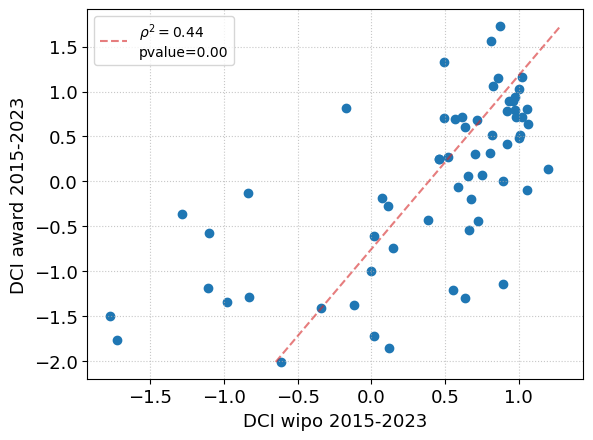

In [99]:
#DCI award vs DCI wipo
plt.rcParams.update({'font.size': 13})

DCIs, non_present = x_vs_y(DCI_awards, DCI_wipo, wipo_awards)
mask_0 = ~(np.isnan(DCIs[0, :]) & np.isnan(DCIs[1, :]))

print(f'Awards vs Wipo: {DCIs[:, mask_0].shape}')

if mask_:
    mask1 = ~(np.isnan(DCIs[0, :]) & np.isnan(DCIs[1, :]))
    mask2 = DCIs[0, mask1] < 6
    DCIs = DCIs[:, mask1][:, mask2]

DCI_reg, values = reg(DCIs, robust = False)



plt.scatter(DCIs[1, :], DCIs[0, :])
plt.plot(DCI_reg[1, :], DCI_reg[0, :], linestyle = '--', alpha = 0.6, color = 'tab:red', label = f'$\\rho^2=${values[0]**2:.2f}\npvalue={values[1]:.2f}')
plt.legend(fontsize = 10)
plt.grid(alpha = 0.7, linestyle = ':')
plt.ylabel(f'DCI award {año_awards}')
plt.xlabel(f'DCI wipo {año_wipo}')

if save:
    plt.savefig(f'./figs/correlations/{folder}DCIs.png')

## DCI awards vs GDP per capita

Awards vs PIB: (2, 73)
Wipo vs PIB: (2, 96)


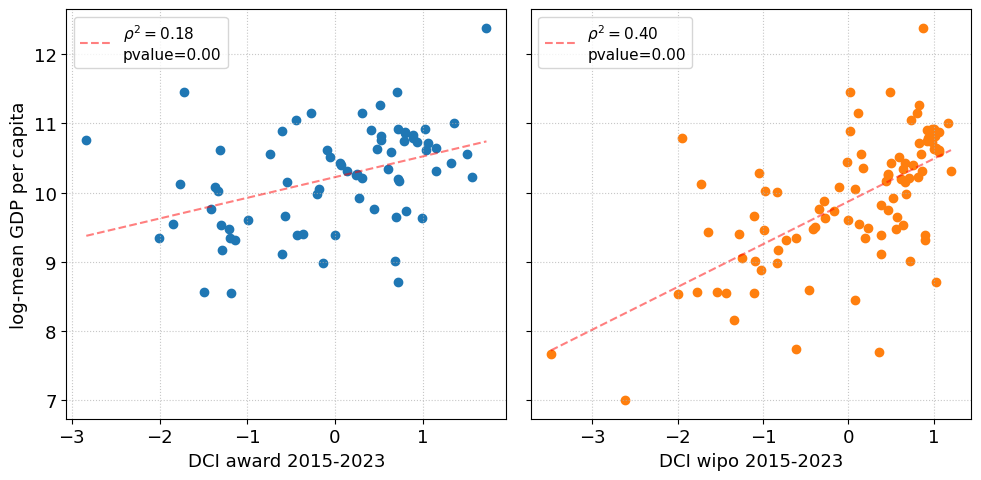

In [101]:
#DCIs vs GDP per capita
escalabilidad = 1

DCIa_PIB, non_present = x_vs_y(DCI_awards, PIB['mean_2'], awards_gdp, log = True)
DCIw_PIB, non_present = x_vs_y(DCI_wipo, PIB['mean_2'], wipo_gdp, log = True)

mask_a = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
mask_w = ~(np.isnan(DCIw_PIB[0, :]) & np.isnan(DCIw_PIB[1, :]))

print(f'Awards vs PIB: {DCIa_PIB[:, mask_a].shape}')
print(f'Wipo vs PIB: {DCIw_PIB[:, mask_w].shape}')

if mask_:
    mask1 = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
    mask2 = DCIa_PIB[0, mask1] < 6
    DCIa_PIB = DCIa_PIB[:, mask1][:, mask2]


DCIa_reg, values_a = reg(DCIa_PIB)
DCIw_reg, values_w = reg(DCIw_PIB)

fig, ax = plt.subplots(1, 2, figsize = (escalabilidad * 10, escalabilidad * 5), sharey = True)

ax[0].scatter(DCIa_PIB[0, :], DCIa_PIB[1, :])
ax[0].plot(DCIa_reg[0, :], DCIa_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2=${values_a[0]**2:.2f}\npvalue={values_a[1]:.2f}')
ax[0].set_xlabel(f'DCI award {año_awards}')
ax[0].set_ylabel(f'log-mean GDP per capita')
ax[0].legend(fontsize = 11, loc = 'upper left')
ax[0].grid(alpha = 0.7, linestyle = ':')

ax[1].scatter(DCIw_PIB[0, :], DCIw_PIB[1, :], color = 'tab:orange')
ax[1].plot(DCIw_reg[0, :], DCIw_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2=${values_w[0]**2:.2f}\npvalue={values_w[1]:.2f}')
ax[1].set_xlabel(f'DCI wipo {año_wipo}')
ax[1].legend(fontsize = 11, loc = 'upper left')
ax[1].grid(alpha = 0.7, linestyle = ':')

plt.tight_layout()
if save:
    plt.savefig(f'./figs/correlations/{folder}DCIs_GDP.png')

## DCI vs GDR 2023

Awards vs GDR2023: (2, 8)
Wipo vs GDR2023: (2, 8)


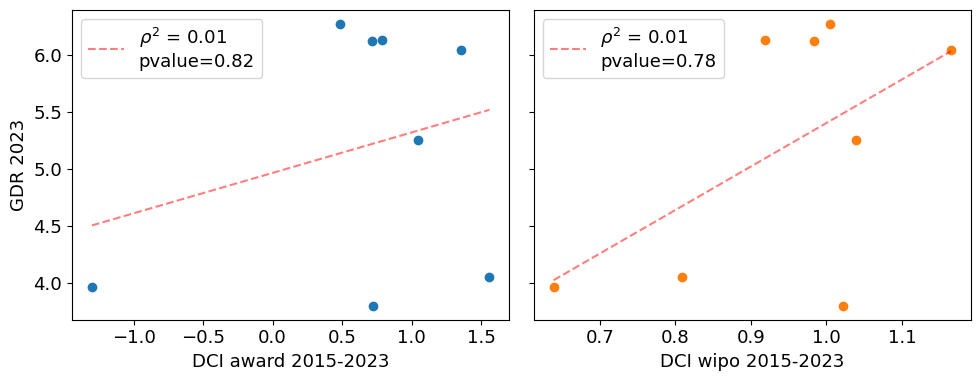

In [104]:
#DCI award vs GDR 2023
wipo_ranking = interchange_dict(wipo_awards, GDR_2023_dict)
DCIa_PIB, non_present_a = x_vs_y(DCI_awards, Ranking_Score['GDR_2023'], GDR_2023_dict)
DCIw_PIB, non_present_w = x_vs_y(DCI_wipo, Ranking_Score['GDR_2023'], wipo_ranking)

mask_a = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
mask_w = ~(np.isnan(DCIw_PIB[0, :]) & np.isnan(DCIw_PIB[1, :]))

print(f'Awards vs GDR2023: {DCIa_PIB[:, mask_a].shape}')
print(f'Wipo vs GDR2023: {DCIw_PIB[:, mask_w].shape}')

if mask_:
    mask1 = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
    mask2 = DCIa_PIB[0, mask1] < 6
    DCIa_PIB = DCIa_PIB[:, mask1][:, mask2]

DCIa_reg, values_a = reg(DCIa_PIB)
DCIw_reg, values_w = reg(DCIw_PIB)

fig, ax = plt.subplots(1, 2, figsize = (10, 4), sharey = True)

ax[0].scatter(DCIa_PIB[0, :], DCIa_PIB[1, :])
ax[0].plot(DCIa_reg[0, :], DCIa_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_a[0]**2:.2f}\npvalue={values_a[1]:.2f}')
ax[0].set_xlabel(f'DCI award {año_awards}')
ax[0].set_ylabel(f'GDR 2023')
ax[0].legend()



ax[1].scatter(DCIw_PIB[0, :], DCIw_PIB[1, :], color = 'tab:orange')
ax[1].plot(DCIw_reg[0, :], DCIw_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_w[0]**2:.2f}\npvalue={values_w[1]:.2f}')
ax[1].set_xlabel(f'DCI wipo {año_wipo}')
ax[1].legend()

plt.tight_layout()
if save:
    plt.savefig(f'./figs/correlations/{folder}DCIs_GDR2023.png')

## DCI vs DCR 20XX

Awards vs ADA_2023: (2, 73)
Wipo vs ADA_2023: (2, 84)

Awards vs DCR_2002: (2, 10)
Wipo vs DCR_2002: (2, 9)

Awards vs DCR_2005: (2, 10)
Wipo vs DCR_2005: (2, 9)

Awards vs DCR_2007: (2, 10)
Wipo vs DCR_2007: (2, 9)

Awards vs DCR_2008: (2, 41)
Wipo vs DCR_2008: (2, 41)

Awards vs DCR_2010: (2, 40)
Wipo vs DCR_2010: (2, 40)

Awards vs GDR_2023: (2, 8)
Wipo vs GDR_2023: (2, 8)

Awards vs IDS_abs: (2, 10)
Wipo vs IDS_abs: (2, 9)

Awards vs IDS_rel: (2, 10)
Wipo vs IDS_rel: (2, 9)



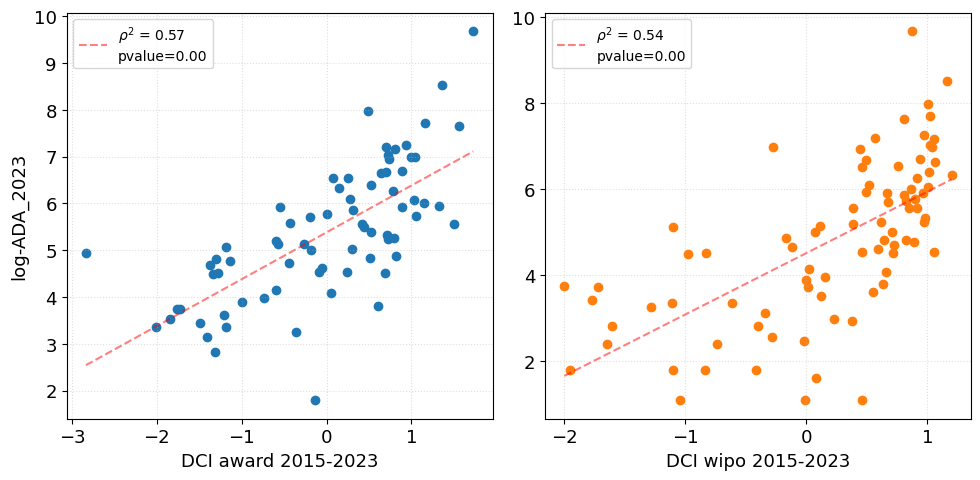

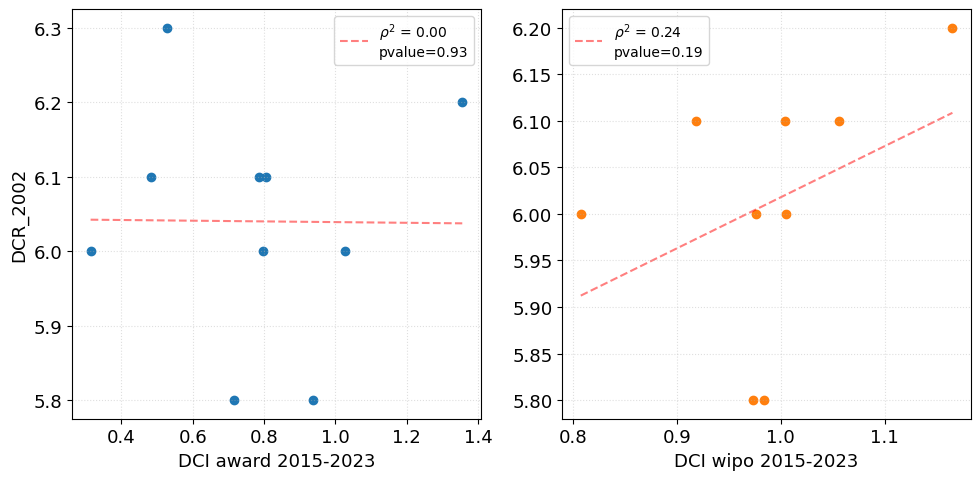

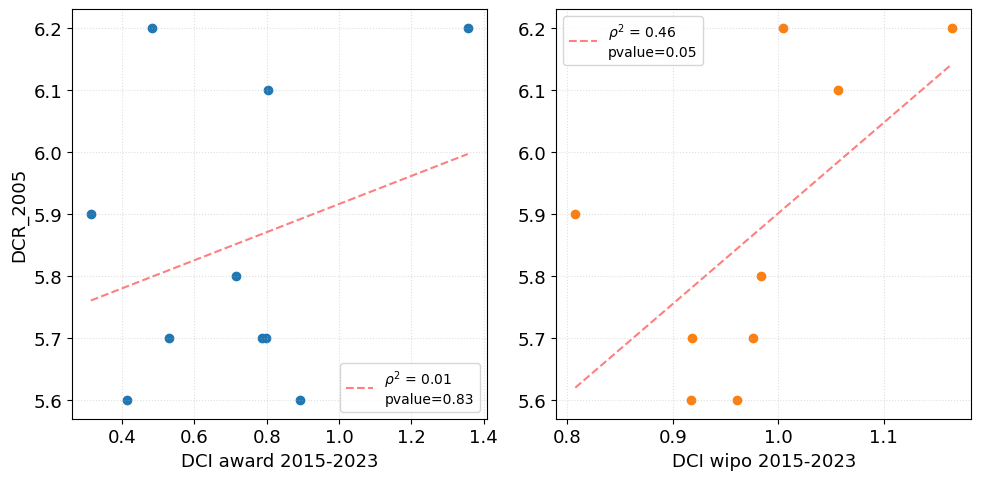

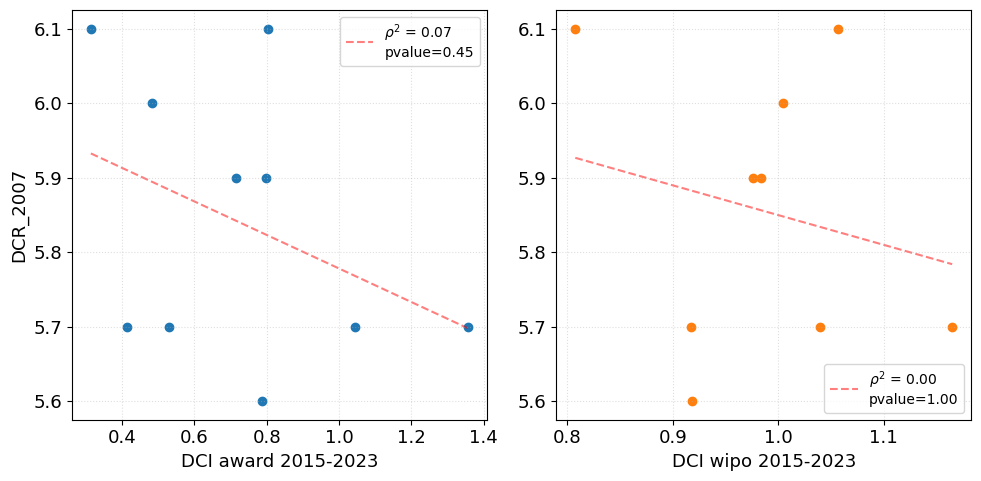

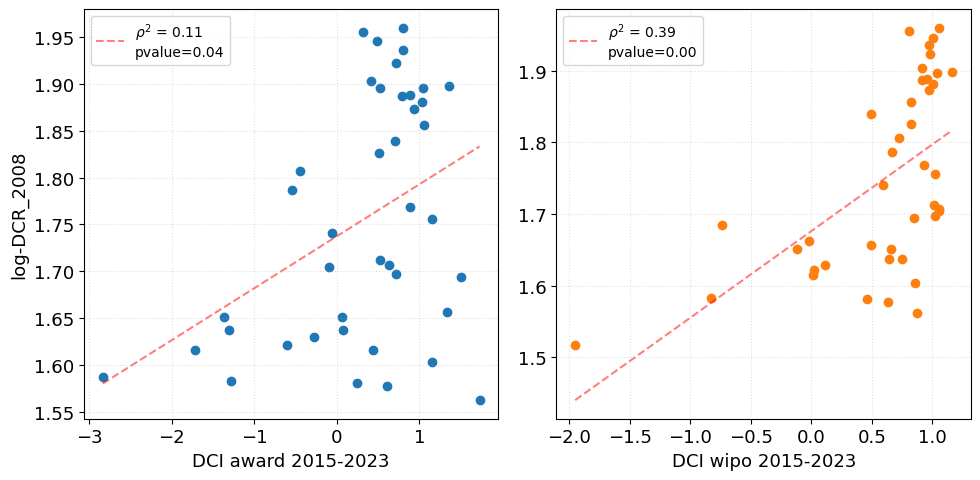

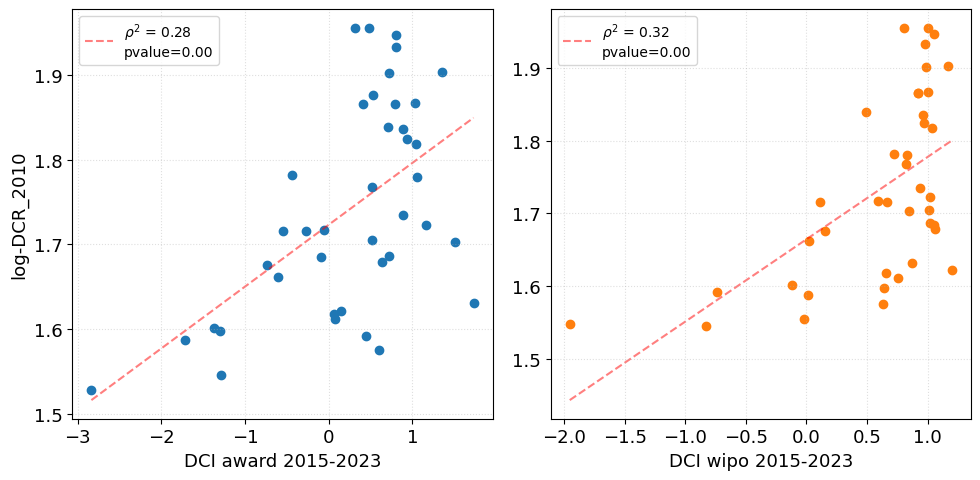

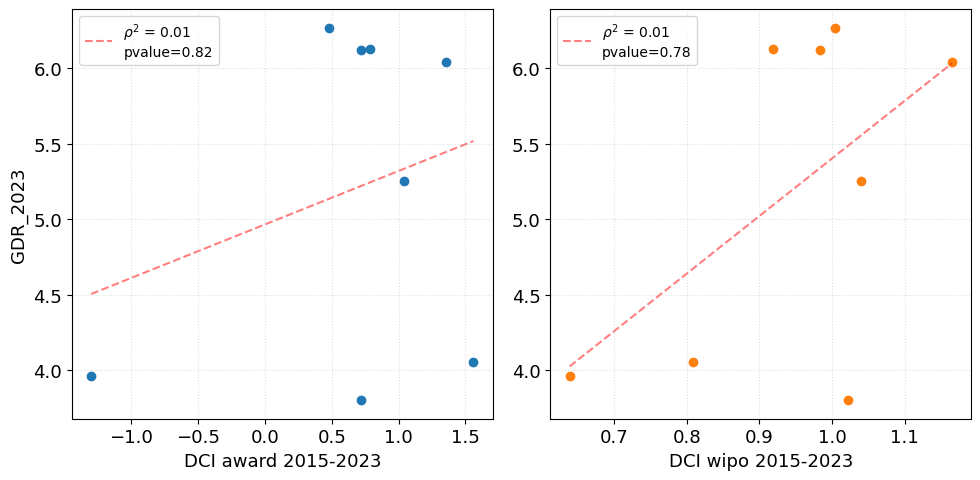

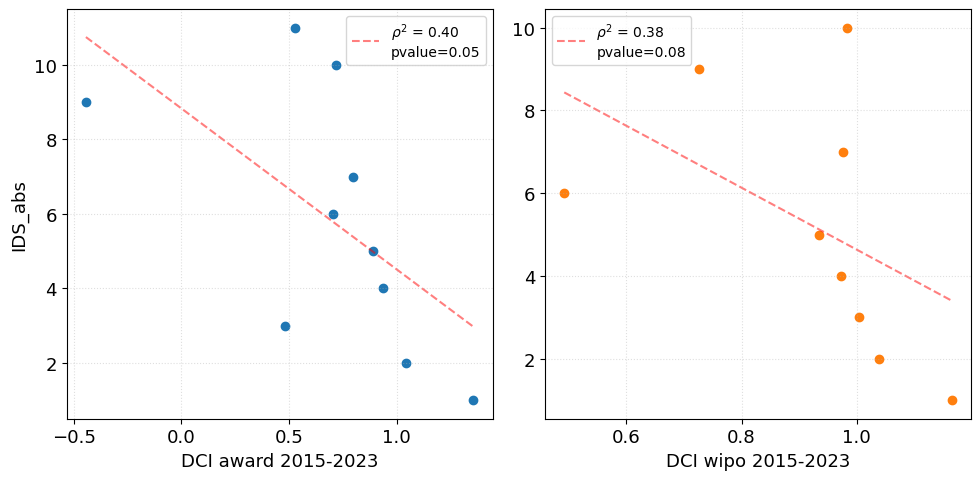

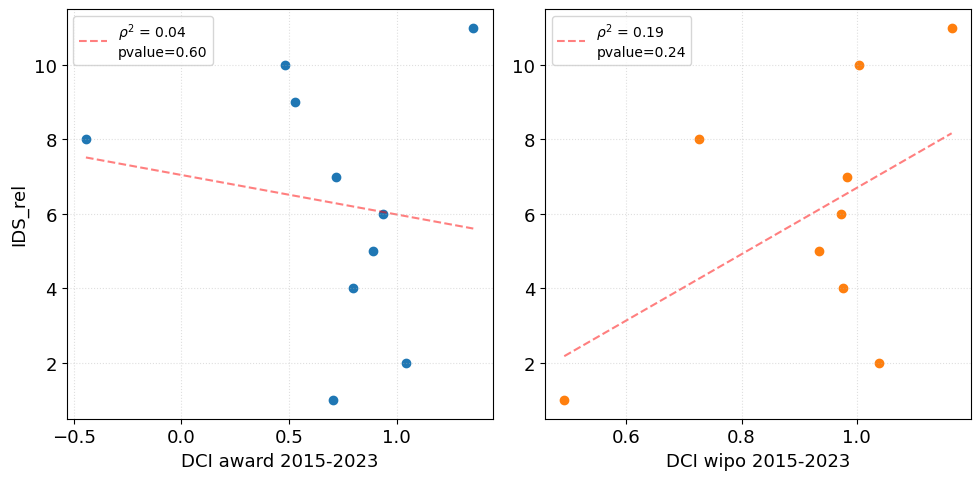

In [106]:
#DCI award vs GDP per capita

for n, rank in enumerate(Ranking_names):
    fig, ax = plt.subplots(1, 2, figsize = (10, 5))

    is_log = (n in [0, 4, 5])
    
    wipo_ranking = interchange_dict(wipo_awards, Ranking_dicts[n])
    DCIa_PIB, non_present = x_vs_y(DCI_awards, Ranking_Score[rank], Ranking_dicts[n], log = is_log)
    DCIw_PIB, non_present = x_vs_y(DCI_wipo, Ranking_Score[rank], wipo_ranking, log = is_log)

    mask_a = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
    mask_w = ~(np.isnan(DCIw_PIB[0, :]) & np.isnan(DCIw_PIB[1, :]))
    
    print(f'Awards vs {rank}: {DCIa_PIB[:, mask_a].shape}')
    print(f'Wipo vs {rank}: {DCIw_PIB[:, mask_w].shape}\n')

    if mask_:
        mask1 = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
        mask2 = DCIa_PIB[0, mask1] < 6
        DCIa_PIB = DCIa_PIB[:, mask1][:, mask2]
    
    DCIa_reg, values_a = reg(DCIa_PIB)
    DCIw_reg, values_w = reg(DCIw_PIB)
    
    ax[0].scatter(DCIa_PIB[0, :], DCIa_PIB[1, :], zorder = 1)
    ax[0].plot(DCIa_reg[0, :], DCIa_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_a[0]**2:.2f}\npvalue={values_a[1]:.2f}', zorder = 1)
    ax[0].set_ylabel( is_log * 'log-' + f'{rank}')
    ax[0].legend(fontsize = 10)
    ax[0].grid(zorder = 0, alpha = 0.4, linestyle = ':')
    
    ax[1].scatter(DCIw_PIB[0, :], DCIw_PIB[1, :], color = 'tab:orange', zorder = 1)
    ax[1].plot(DCIw_reg[0, :], DCIw_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_w[0]**2:.2f}\npvalue={values_w[1]:.2f}', zorder = 1)
    ax[1].legend(fontsize = 10)
    ax[1].grid(zorder = 0, alpha = 0.4, linestyle = ':')

    ax[0].set_xlabel(f'DCI award {año_awards}')
    ax[1].set_xlabel(f'DCI wipo {año_wipo}')
    plt.tight_layout()

    if save:
        plt.savefig(f'./figs/correlations/{folder}DCIs_{rank}.png')

## DCI vs IDS

Awards vs IDS_abs: (2, 10)
Wipo vs IDS_abs: (2, 9)
Awards vs IDS_rel: (2, 6)
Wipo vs IDS_rel: (2, 5)


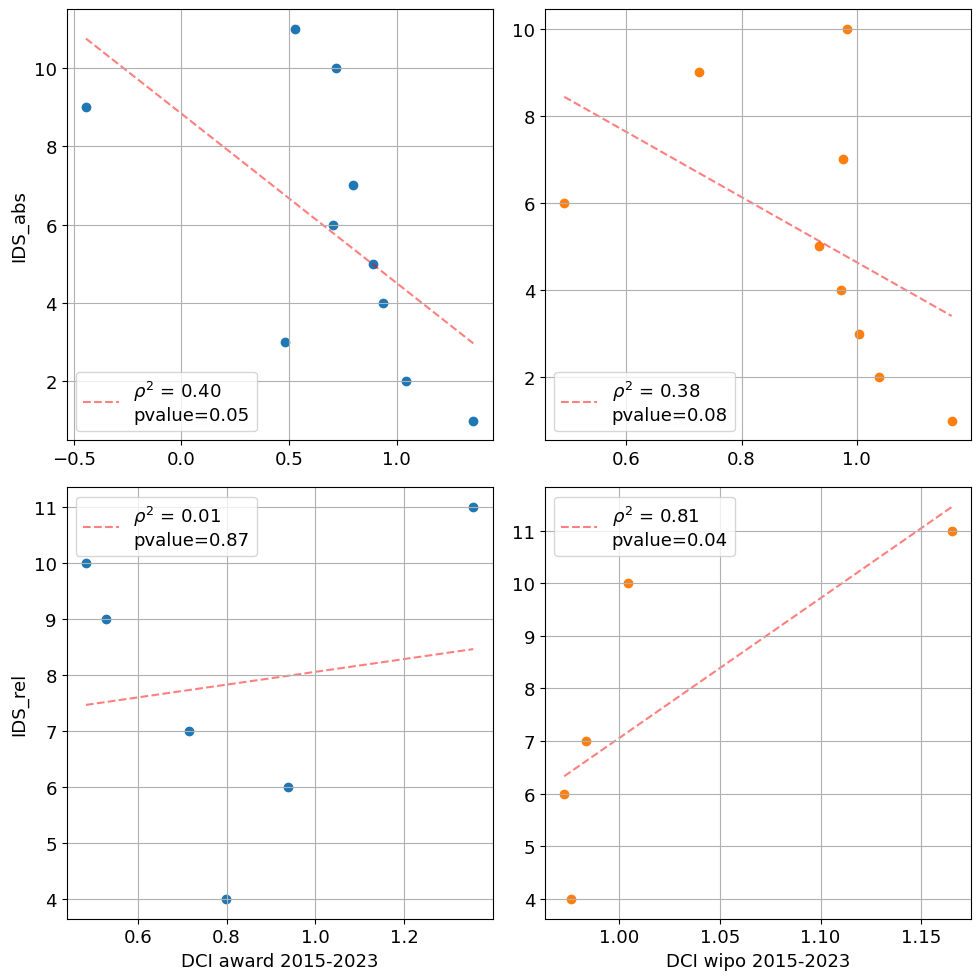

In [109]:
fig, ax = plt.subplots(2, 2, figsize = (10, 5 * 2))

for n, rank in enumerate(Ranking_names[7:]):
    wipo_ranking = interchange_dict(wipo_awards, Ranking_dicts[n])
    DCIa_PIB, non_present = x_vs_y(DCI_awards, Ranking_Score[rank], Ranking_dicts[n])
    DCIw_PIB, non_present = x_vs_y(DCI_wipo, Ranking_Score[rank], wipo_ranking)

    mask_a = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
    mask_w = ~(np.isnan(DCIw_PIB[0, :]) & np.isnan(DCIw_PIB[1, :]))
    
    print(f'Awards vs {rank}: {DCIa_PIB[:, mask_a].shape}')
    print(f'Wipo vs {rank}: {DCIw_PIB[:, mask_w].shape}')

    if mask_:
        mask1 = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
        mask2 = DCIa_PIB[0, mask1] < 6
        DCIa_PIB = DCIa_PIB[:, mask1][:, mask2]
    
    DCIa_reg, values_a = reg(DCIa_PIB)
    DCIw_reg, values_w = reg(DCIw_PIB)
    
    ax[n, 0].scatter(DCIa_PIB[0, :], DCIa_PIB[1, :], zorder = 1)
    ax[n, 0].plot(DCIa_reg[0, :], DCIa_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_a[0]**2:.2f}\npvalue={values_a[1]:.2f}', zorder = 1)
    ax[n, 0].set_ylabel(f'{rank}')
    ax[n, 0].legend()
    ax[n, 0].grid(zorder = 0)
    
    ax[n, 1].scatter(DCIw_PIB[0, :], DCIw_PIB[1, :], color = 'tab:orange', zorder = 1)
    ax[n, 1].plot(DCIw_reg[0, :], DCIw_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_w[0]**2:.2f}\npvalue={values_w[1]:.2f}', zorder = 1)
    ax[n, 1].legend()
    ax[n, 1].grid(zorder = 0)

ax[1, 0].set_xlabel(f'DCI award {año_awards}')
ax[1, 1].set_xlabel(f'DCI wipo {año_wipo}')
plt.tight_layout()

if save:
    plt.savefig(f'./figs/correlations/{folder}DCIs_IDS.png')

Awards vs ECI_tr: (2, 70)
Wipo vs ECI_tr: (2, 79)
Awards vs ECI_te: (2, 70)
Wipo vs ECI_te: (2, 79)
Awards vs ECI_re: (2, 70)
Wipo vs ECI_re: (2, 79)


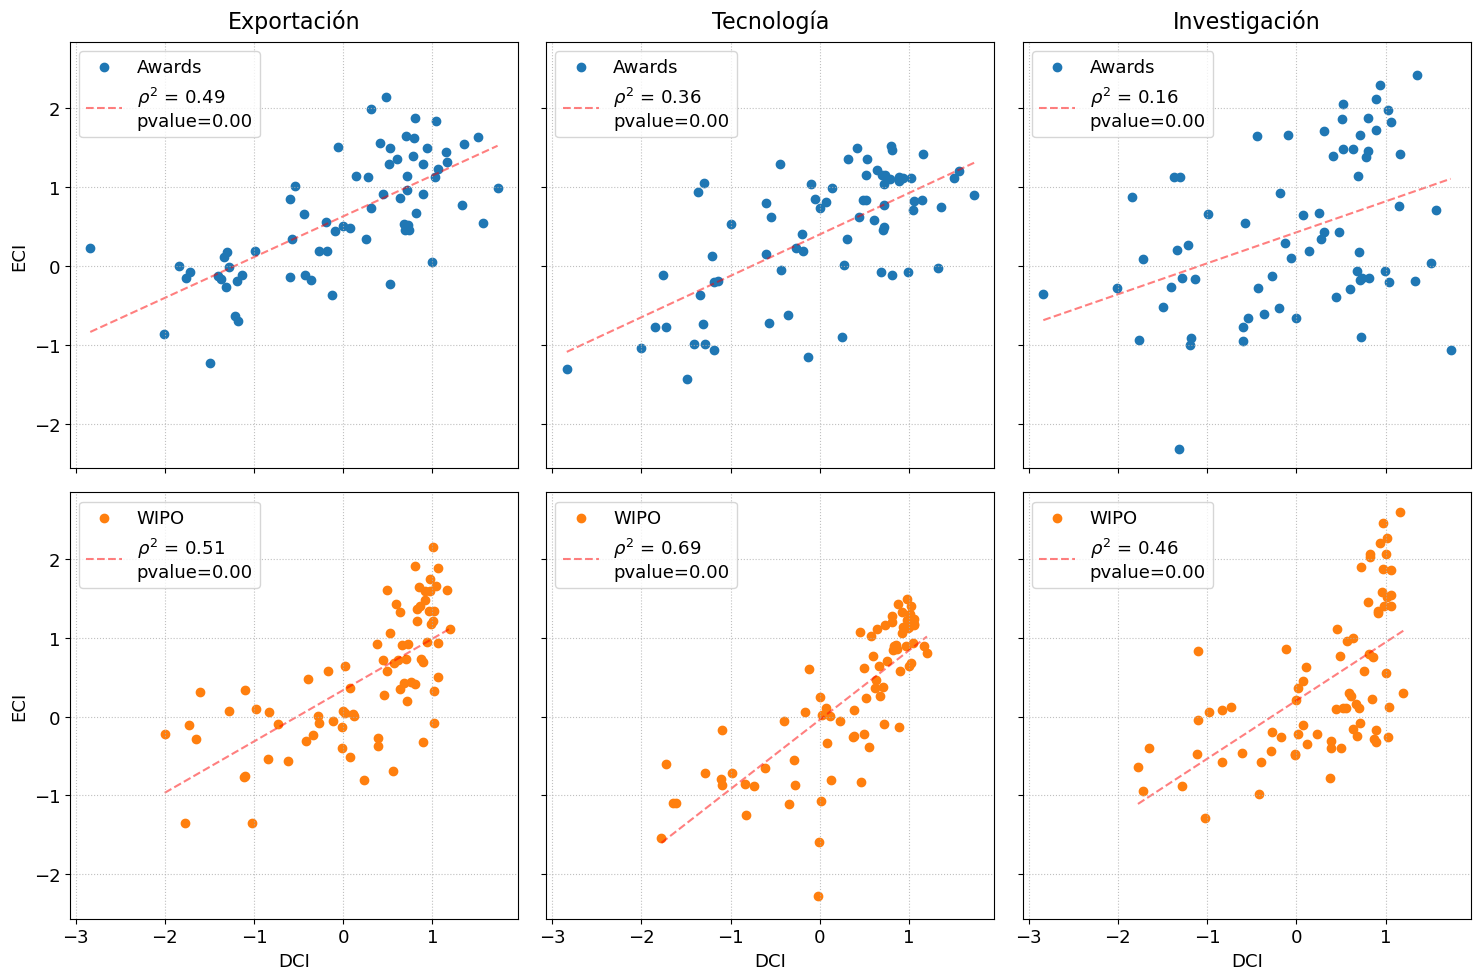

In [110]:
fig, ax = plt.subplots(2, 3, figsize = (5 * 3, 10), sharex = True, sharey = True)

for n, rank in enumerate(ECI_names):
    wipo_ranking = interchange_dict(wipo_awards, awards_OEC)
    DCIa_PIB, non_present = x_vs_y(DCI_awards, ECIs[rank]['mean_awards'], awards_OEC)
    DCIw_PIB, non_present = x_vs_y(DCI_wipo, ECIs[rank]['mean_1'], wipo_ranking)

    mask_a = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
    mask_w = ~(np.isnan(DCIw_PIB[0, :]) & np.isnan(DCIw_PIB[1, :]))
    
    print(f'Awards vs {rank}: {DCIa_PIB[:, mask_a].shape}')
    print(f'Wipo vs {rank}: {DCIw_PIB[:, mask_w].shape}')

    if mask_:
        mask1 = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
        mask2 = DCIa_PIB[0, mask1] < 6
        DCIa_PIB = DCIa_PIB[:, mask1][:, mask2]
    
    DCIa_reg, values_a = reg(DCIa_PIB)
    DCIw_reg, values_w = reg(DCIw_PIB)
    
    ax[0, n].scatter(DCIa_PIB[0, :], DCIa_PIB[1, :], zorder = 1, label = 'Awards')
    ax[0, n].plot(DCIa_reg[0, :], DCIa_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_a[0]**2:.2f}\npvalue={values_a[1]:.2f}', zorder = 1)
    ax[0, n].legend(loc = 'upper left', fontsize = 13)
    ax[0, n].grid(zorder = 0, alpha = 0.8, linestyle = ':')
    
    ax[1, n].scatter(DCIw_PIB[0, :], DCIw_PIB[1, :], color = 'tab:orange', zorder = 1, label = 'WIPO')
    ax[1, n].plot(DCIw_reg[0, :], DCIw_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_w[0]**2:.2f}\npvalue={values_w[1]:.2f}', zorder = 1)
    ax[1, n].legend(loc = 'upper left', fontsize = 13)
    ax[1, n].grid(zorder = 0, alpha = 0.8, linestyle = ':')

    #ax[1, 0].set_xlabel(f'DCI award {año_awards}')
    #ax[1, 1].set_xlabel(f'DCI wipo {año_wipo}')
    ax[0, 0].set_ylabel(f'ECI')
    ax[1, 0].set_ylabel(f'ECI')

for n, titulos in enumerate(['Exportación', 'Tecnología', 'Investigación']):
    ax[0, n].set_title(titulos, pad = 10, fontsize = 16)
    ax[1, n].set_xlabel('DCI')

plt.tight_layout()
if save:
    plt.savefig(f'./figs/correlations/{folder}DCIs_ECIs.png')

## DCIs vs GCIs

Awards vs GCI_2011: (2, 59)
Wipo vs GCI_2011: (2, 59)
Awards vs GCI_2015: (2, 63)
Wipo vs GCI_2015: (2, 70)


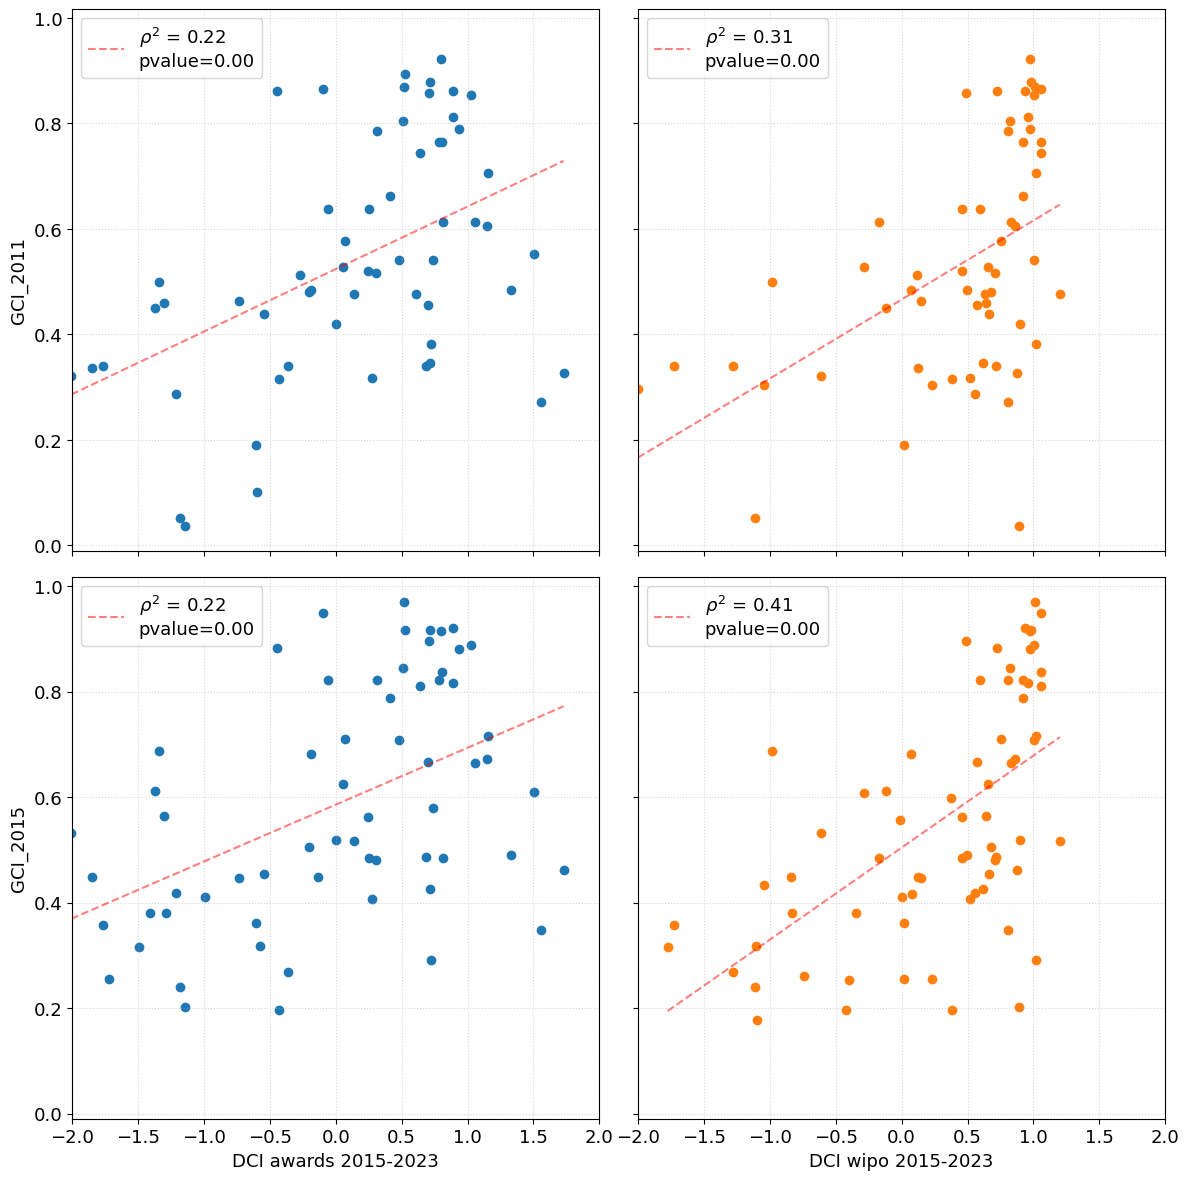

In [113]:
#DCI award vs GDR 2023
fig, ax = plt.subplots(2, 2, figsize = (12, 12), sharey = True, sharex = True)
for n, rank in enumerate(GCI_names):
    DCIa_PIB, non_present_a = x_vs_y(DCI_awards, GCIs[rank], awards_wipo)
    DCIw_PIB, non_present_w = x_vs_y(DCI_wipo, GCIs[rank], identity_dict(awards_wipo))
    
    mask_a = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
    mask_w = ~(np.isnan(DCIw_PIB[0, :]) & np.isnan(DCIw_PIB[1, :]))
    
    print(f'Awards vs {rank}: {DCIa_PIB[:, mask_a].shape}')
    print(f'Wipo vs {rank}: {DCIw_PIB[:, mask_w].shape}')

    if mask_:
        mask1 = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
        mask2 = DCIa_PIB[0, mask1] < 6
        DCIa_PIB = DCIa_PIB[:, mask1][:, mask2]
    
    DCIa_reg, values_a = reg(DCIa_PIB)
    DCIw_reg, values_w = reg(DCIw_PIB)
    
    ax[n, 0].scatter(DCIa_PIB[0, :], DCIa_PIB[1, :])
    ax[n, 0].plot(DCIa_reg[0, :], DCIa_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_a[0]**2:.2f}\npvalue={values_a[1]:.2f}')
    ax[n, 0].set_ylabel(f'{rank}')
    ax[n, 0].legend(loc = 'upper left', fontsize = 13)
    ax[n, 0].grid(alpha = 0.5, linestyle = ':')
    ax[n, 0].set_xlim([-2, 2])

    ax[n, 1].scatter(DCIw_PIB[0, :], DCIw_PIB[1, :], color = 'tab:orange')
    ax[n, 1].plot(DCIw_reg[0, :], DCIw_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_w[0]**2:.2f}\npvalue={values_w[1]:.2f}')
    ax[n, 1].legend(loc = 'upper left', fontsize = 13)
    ax[n, 1].grid(alpha = 0.5, linestyle = ':')

ax[1, 0].set_xlabel(f'DCI awards {año_awards}')
ax[1, 1].set_xlabel(f'DCI wipo {año_wipo}')
plt.tight_layout()

if save:
    plt.savefig(f'./figs/correlations/{folder}DCIs_GCIs.png')

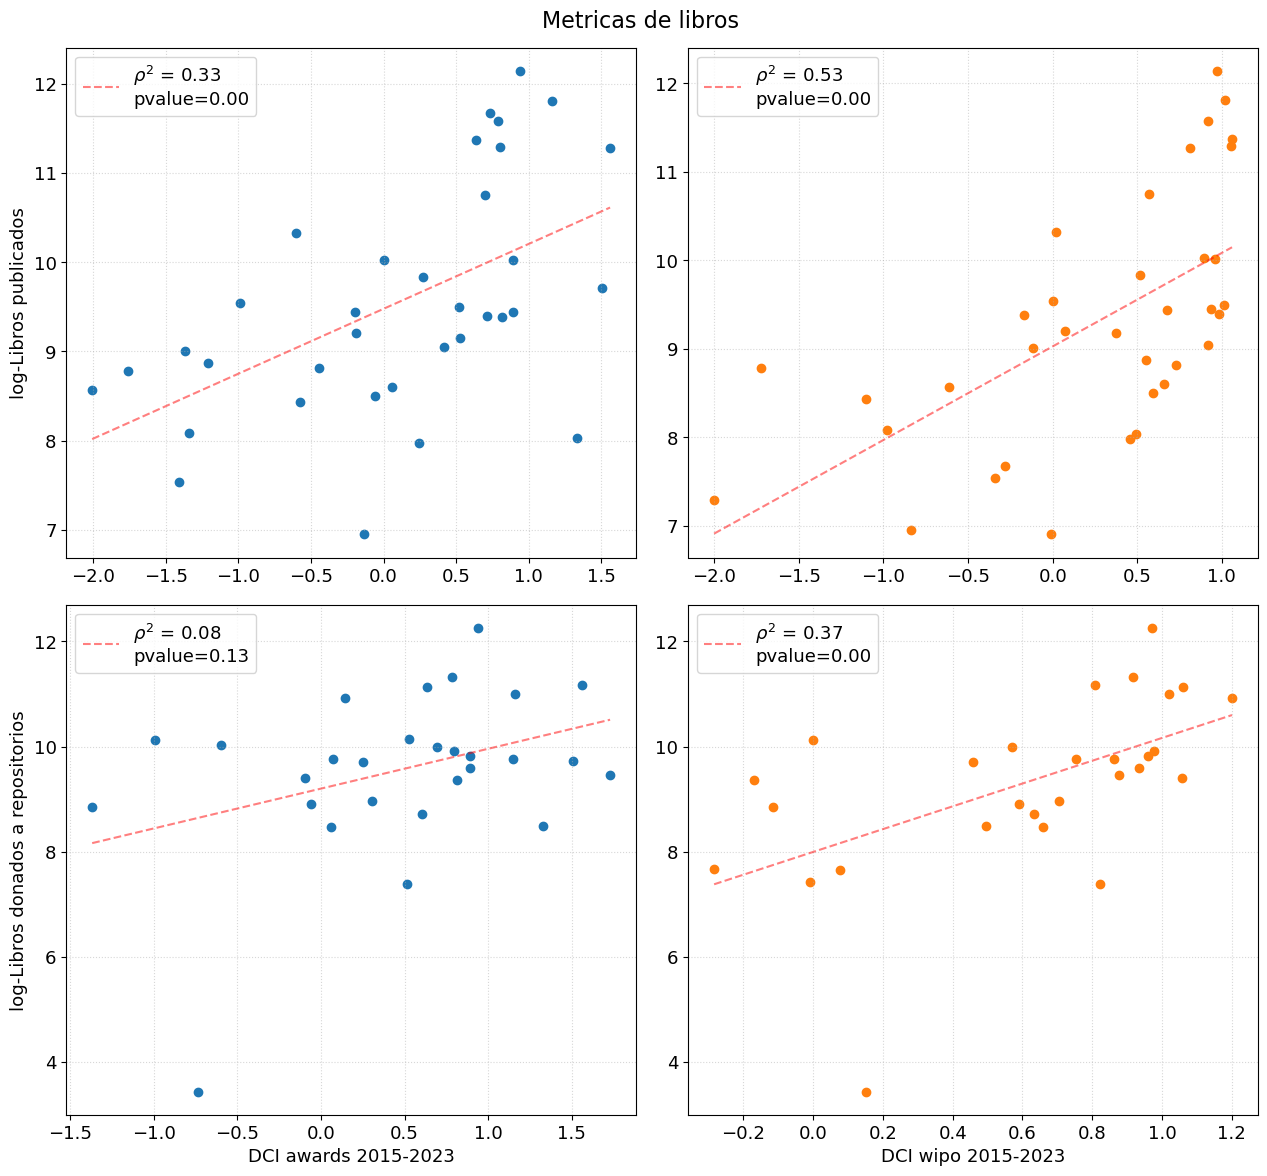

In [114]:
#Libros publicados
fig, ax = plt.subplots(2, 2, figsize = (13, 12))
Nombres_y = ['Libros publicados', 'Libros donados a repositorios']

for n, rank in enumerate(F_names):
    DCIa_PIB, non_present_a = x_vs_y(DCI_awards, Fs[rank], awards_wipo, log = True)
    DCIw_PIB, non_present_w = x_vs_y(DCI_wipo, Fs[rank], identity_dict(awards_wipo), log = True)

    if mask_:
        mask1 = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
        mask2 = DCIa_PIB[0, mask1] < 6
        DCIa_PIB = DCIa_PIB[:, mask1][:, mask2]
    
    DCIa_reg, values_a = reg(DCIa_PIB)
    DCIw_reg, values_w = reg(DCIw_PIB)
    
    ax[n, 0].scatter(DCIa_PIB[0, :], DCIa_PIB[1, :])
    ax[n, 0].plot(DCIa_reg[0, :], DCIa_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_a[0]**2:.2f}\npvalue={values_a[1]:.2f}')
    ax[n, 0].set_ylabel(f'log-{Nombres_y[n]}')
    ax[n, 0].legend(loc = 'upper left', fontsize = 13)
    ax[n, 0].grid(alpha = 0.5, linestyle = ':')
    
    ax[n, 1].scatter(DCIw_PIB[0, :], DCIw_PIB[1, :], color = 'tab:orange')
    ax[n, 1].plot(DCIw_reg[0, :], DCIw_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_w[0]**2:.2f}\npvalue={values_w[1]:.2f}')
    ax[n, 1].legend(loc = 'upper left', fontsize = 13)
    ax[n, 1].grid(alpha = 0.5, linestyle = ':')

ax[1, 0].set_xlabel(f'DCI awards {año_awards}')
ax[1, 1].set_xlabel(f'DCI wipo {año_wipo}')
fig.suptitle('Metricas de libros', fontsize = 16)

plt.tight_layout()
if save:
    plt.savefig(f'./figs/correlations/{folder}DCIs_Fs.png')

Awards vs Times: (2, 59)
Wipo vs Times: (2, 64)


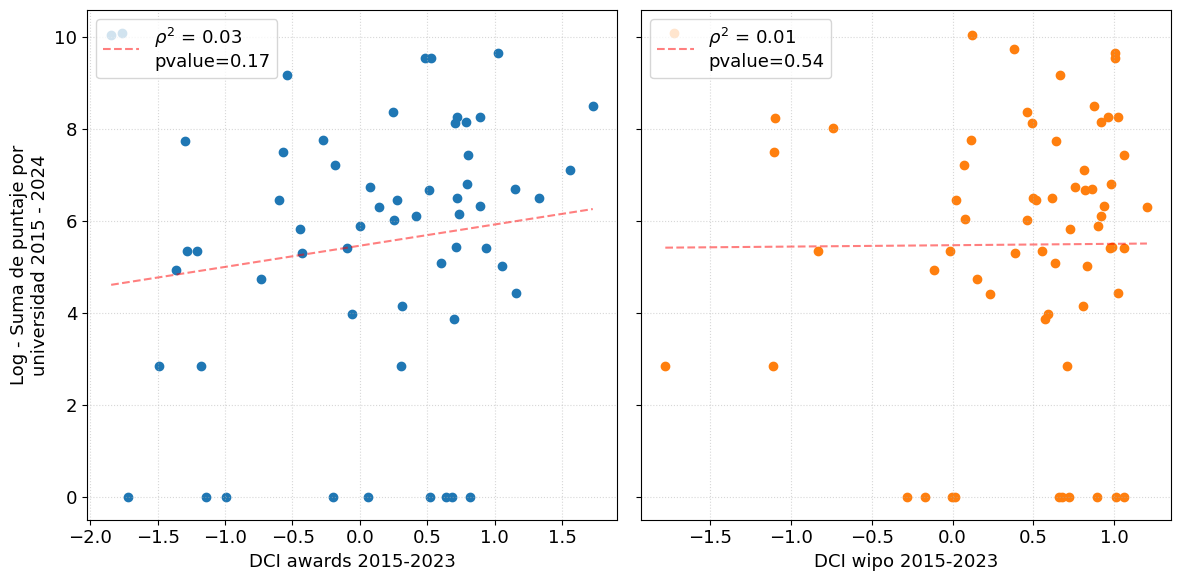

In [115]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6), sharey = True)

DCIa_PIB, non_present_a = x_vs_y(DCI_awards, times_score['mean_awards'], awards_wipo)
DCIw_PIB, non_present_w = x_vs_y(DCI_wipo, times_score['mean_awards'], identity_dict(awards_wipo))

if mask_:
    mask1 = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
    mask2 = DCIa_PIB[0, mask1] < 6
    DCIa_PIB = DCIa_PIB[:, mask1][:, mask2]

DCIa_reg, values_a = reg(DCIa_PIB)
DCIw_reg, values_w = reg(DCIw_PIB)

mask_a = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
mask_w = ~(np.isnan(DCIw_PIB[0, :]) & np.isnan(DCIw_PIB[1, :]))

print(f'Awards vs Times: {DCIa_PIB[:, mask_a].shape}')
print(f'Wipo vs Times: {DCIw_PIB[:, mask_w].shape}')

ax[0].scatter(DCIa_PIB[0, :], DCIa_PIB[1, :])
ax[0].plot(DCIa_reg[0, :], DCIa_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_a[0]**2:.2f}\npvalue={values_a[1]:.2f}')
ax[0].set_ylabel(f'Log - Suma de puntaje por\nuniversidad 2015 - 2024')
ax[0].legend(loc = 'upper left', fontsize = 13)
ax[0].grid(alpha = 0.5, linestyle = ':')

ax[1].scatter(DCIw_PIB[0, :], DCIw_PIB[1, :], color = 'tab:orange')
ax[1].plot(DCIw_reg[0, :], DCIw_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_w[0]**2:.2f}\npvalue={values_w[1]:.2f}')
ax[1].legend(loc = 'upper left', fontsize = 13)
ax[1].grid(alpha = 0.5, linestyle = ':')

ax[0].set_xlabel(f'DCI awards {año_awards}')
ax[1].set_xlabel(f'DCI wipo {año_wipo}')
plt.tight_layout()
if save:
    plt.savefig(f'./figs/correlations/{folder}DCIs_Times.png')

Awards vs Alex: (2, 61)
Wipo vs Alex: (2, 73)


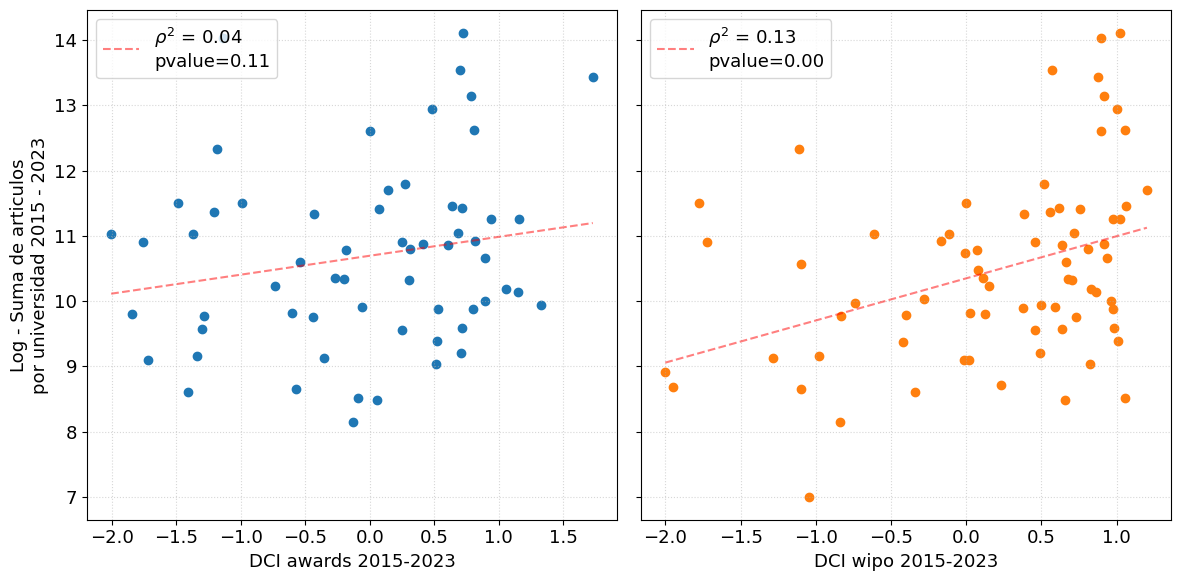

In [116]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6), sharey = True)

DCIa_PIB, non_present_a = x_vs_y(DCI_awards, alex_score['mean_awards'], awards_wipo)
DCIw_PIB, non_present_w = x_vs_y(DCI_wipo, alex_score['mean_awards'], identity_dict(awards_wipo))

mask_a = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
mask_w = ~(np.isnan(DCIw_PIB[0, :]) & np.isnan(DCIw_PIB[1, :]))

print(f'Awards vs Alex: {DCIa_PIB[:, mask_a].shape}')
print(f'Wipo vs Alex: {DCIw_PIB[:, mask_w].shape}')

if mask_:
    mask1 = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
    mask2 = DCIa_PIB[0, mask1] < 6
    DCIa_PIB = DCIa_PIB[:, mask1][:, mask2]

DCIa_reg, values_a = reg(DCIa_PIB)
DCIw_reg, values_w = reg(DCIw_PIB)

ax[0].scatter(DCIa_PIB[0, :], DCIa_PIB[1, :])
ax[0].plot(DCIa_reg[0, :], DCIa_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_a[0]**2:.2f}\npvalue={values_a[1]:.2f}')
ax[0].set_ylabel(f'Log - Suma de articulos\npor universidad 2015 - 2023')
ax[0].legend(loc = 'upper left', fontsize = 13)
ax[0].grid(alpha = 0.5, linestyle = ':')

ax[1].scatter(DCIw_PIB[0, :], DCIw_PIB[1, :], color = 'tab:orange')
ax[1].plot(DCIw_reg[0, :], DCIw_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_w[0]**2:.2f}\npvalue={values_w[1]:.2f}')
ax[1].legend(loc = 'upper left', fontsize = 13)
ax[1].grid(alpha = 0.5, linestyle = ':')

ax[0].set_xlabel(f'DCI awards {año_awards}')
ax[1].set_xlabel(f'DCI wipo {año_wipo}')
plt.tight_layout()

if save:
    plt.savefig(f'./figs/correlations/{folder}DCIs_Alex.png')

Awards vs ECI_tr: (2, 63)
Wipo vs ECI_tr: (2, 73)

Awards vs ECI_te: (2, 63)
Wipo vs ECI_te: (2, 73)

Awards vs ECI_re: (2, 63)
Wipo vs ECI_re: (2, 73)



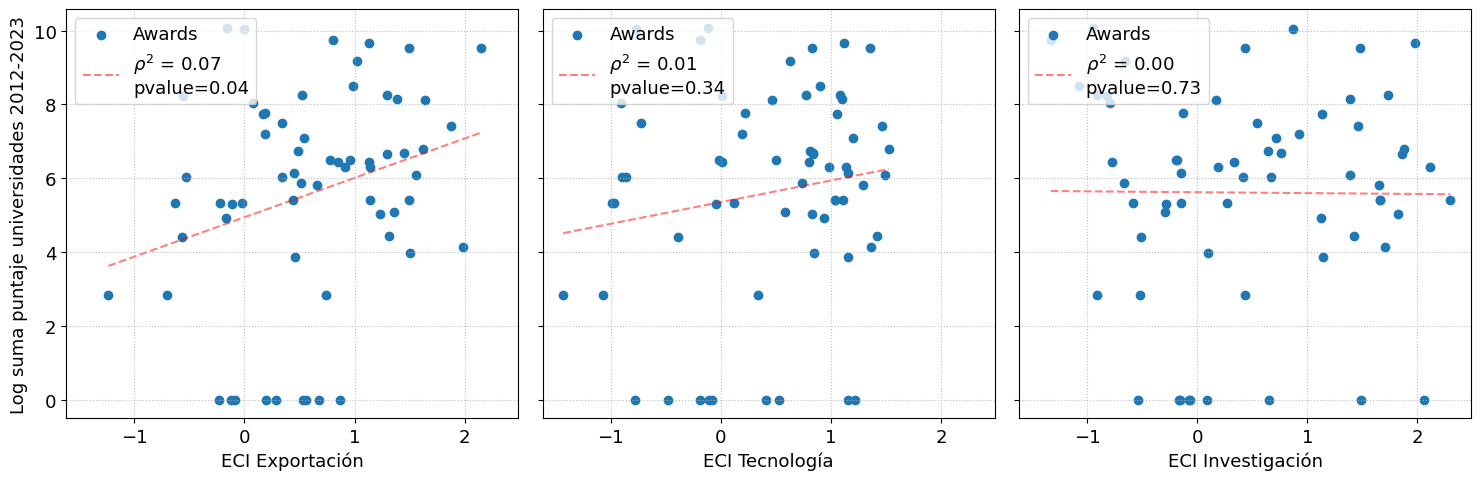

In [117]:
fig, ax = plt.subplots(1, 3, figsize = (5 * 3, 5), sharex = True, sharey = True)

for n, rank in enumerate(ECI_names):
    wipo_ranking = interchange_dict(wipo_awards, awards_OEC)
    DCIa_PIB, non_present = x_vs_y(ECIs[rank]['mean_awards'], times_score['mean_awards'], OEC_wipo)

    mask_a = ~(np.isnan(DCIa_PIB[0, :]) & np.isnan(DCIa_PIB[1, :]))
    mask_w = ~(np.isnan(DCIw_PIB[0, :]) & np.isnan(DCIw_PIB[1, :]))
    
    print(f'Awards vs {rank}: {DCIa_PIB[:, mask_a].shape}')
    print(f'Wipo vs {rank}: {DCIw_PIB[:, mask_w].shape}\n')
    
    DCIa_reg, values_a = reg(DCIa_PIB)
    
    ax[n].scatter(DCIa_PIB[0, :], DCIa_PIB[1, :], zorder = 1, label = 'Awards')
    ax[n].plot(DCIa_reg[0, :], DCIa_reg[1, :], color = 'red', linestyle = '--', alpha = 0.5, label = f'$\\rho^2$ = {values_a[0]**2:.2f}\npvalue={values_a[1]:.2f}', zorder = 1)
    ax[n].legend(loc = 'upper left', fontsize = 13)
    ax[n].grid(zorder = 0, alpha = 0.8, linestyle = ':')

    #ax[1, 0].set_xlabel(f'DCI award {año_awards}')
    #ax[1, 1].set_xlabel(f'DCI wipo {año_wipo}')
    ax[0].set_ylabel(f'Log suma puntaje universidades 2012-2023')

for n, titulos in enumerate(['Exportación', 'Tecnología', 'Investigación']):
    ax[n].set_xlabel(f'ECI {titulos}')

plt.tight_layout()

In [ ]:
# Normalizar las llaves de los diccionarios usando equivalencias
def normalizar_diccionario(dic, equivalencias):
    resultado = {}
    for k, v in dic.items():
        clave_normalizada = equivalencias.get(k, k)
        resultado[clave_normalizada] = v
    return resultado


# Normalizar ambos diccionarios
dict1_norm = normalizar_diccionario(DCI_awards, awards_wipo)
dict2_norm = normalizar_diccionario(DCI_wipo, {})
dict3_norm = normalizar_diccionario(PIB['mean_awards'], inv_dict(wipo_gdp))
dict4_norm = normalizar_diccionario(ECIs['ECI_tr']['mean_awards'], inv_dict(wipo_ranking))
dict5_norm = normalizar_diccionario(ECIs['ECI_re']['mean_awards'], inv_dict(wipo_ranking))
dict6_norm = normalizar_diccionario(ECIs['ECI_te']['mean_awards'], inv_dict(wipo_ranking))
dict7_norm = normalizar_diccionario(Fs['F23_2018'], identity_dict(wipo_ranking))
dict8_norm = normalizar_diccionario(Fs['F25_2018'], identity_dict(wipo_ranking))
dict9_norm = normalizar_diccionario(times_score['mean_awards'], awards_wipo)
dict10_norm = normalizar_diccionario(alex_score['mean_awards'], awards_wipo)


times_score, identity_dict(awards_wipo)
# Crear dataframe combinando
todos_paises = set(dict1_norm) | set(dict2_norm)
datos = []

for pais in todos_paises:
    valor1 = dict1_norm.get(pais, None)
    valor2 = dict2_norm.get(pais, None)
    valor3 = dict3_norm.get(pais, None)
    valor4 = dict4_norm.get(pais, None)
    valor5 = dict5_norm.get(pais, None)
    valor6 = dict6_norm.get(pais, None)
    valor7 = dict7_norm.get(pais, None)
    valor8 = dict8_norm.get(pais, None)
    valor9 = dict9_norm.get(pais, None)
    valor10 = dict10_norm.get(pais, None)
    datos.append({
        'País': pais,
        'DCI_awards': valor1,
        'DCI_wipo': valor2,
        'PIB_per_capita': valor3,
        'ECI_tr': valor4,
        'ECI_re': valor5,
        'ECI_te': valor6,
        'F23_2018': valor7,
        'F25_2018': valor8,
        'Times_Score': valor9,
        'Alex_Score': valor10
        
    })

df = pd.DataFrame(datos)

# (Opcional) ordenar por nombre de país
df = df.sort_values('País').reset_index(drop=True)

df

In [ ]:
df.to_csv('./data/results/DataFrame_total.csv')